# Dual Momentum

Description

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_cdi, historic_imab5, historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [28]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [29]:
trading_days = ibov_prices.index.to_frame(index=False, name='Date')

In [30]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

In [31]:
cdi_normalized = pd.merge(trading_days, cdi, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()
imab5_normalized = pd.merge(trading_days, imab5, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()

In [32]:
relative_prices = pd.merge(ibov_prices, sp500_prices, left_index=True, right_index=True, how='left')
relative_prices = (relative_prices / relative_prices.iloc[0])
relative_prices = relative_prices.set_axis(['IBOV', 'SP500 BRL'], axis=1)

relative_prices['SP500 BRL'] = relative_prices['SP500 BRL'].ffill()

In [33]:
prices = pd.concat([cdi, imab5, relative_prices['IBOV'], relative_prices['SP500 BRL']], keys=['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL'], join='inner', axis=1)
prices = (prices / prices.iloc[0])
prices = prices.dropna()

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,1.000000,1.000000
2004-01-05,1.000601,1.000576,1.048429,1.004152
2004-01-06,1.001202,1.001922,1.050390,1.001270
2004-01-07,1.001803,1.003517,1.038984,1.011210
2004-01-08,1.002405,1.007081,1.056672,1.011452
...,...,...,...,...
2024-09-03,8.218644,11.254458,5.985877,9.716471
2024-09-04,8.221871,11.275119,6.064201,9.724193
2024-09-05,8.225100,11.288138,6.081622,9.641519
2024-09-06,8.228330,11.287673,5.995634,9.416444


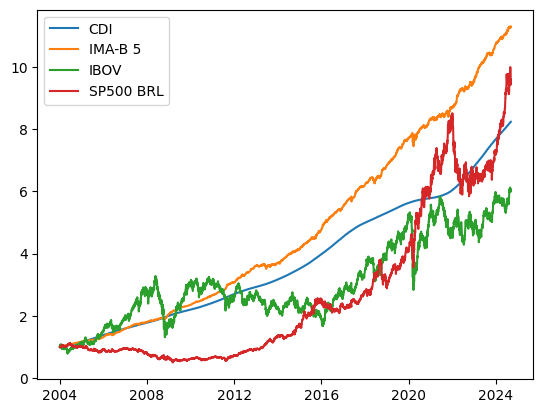

In [34]:
plt.plot(prices)
plt.legend(prices.columns)
plt.show()

In [35]:
ytd_returns = prices.pct_change(periods=252).dropna()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-06,0.164780,0.177314,0.085632,0.010189
2005-01-07,0.164836,0.176687,0.051632,-0.001890
2005-01-10,0.164891,0.175603,0.030370,0.002217
2005-01-11,0.164947,0.174425,0.045026,-0.008823
2005-01-12,0.165002,0.170868,0.033436,-0.004859
...,...,...,...,...
2024-09-03,0.113408,0.079185,0.143089,0.415168
2024-09-04,0.113300,0.083757,0.175986,0.402245
2024-09-05,0.113191,0.084500,0.157847,0.385041
2024-09-06,0.113082,0.084395,0.142600,0.352708


In [36]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-06,0.164780,0.177314,0.085632,0.010189
2005-02-01,0.166668,0.161056,-0.003178,-0.049707
2005-03-01,0.168233,0.140095,0.299620,-0.078977
2005-04-01,0.170637,0.137230,0.274952,-0.043001
2005-05-02,0.173259,0.140051,0.158554,-0.115155
...,...,...,...,...
2024-05-02,0.124183,0.084812,0.235118,0.249861
2024-06-03,0.121508,0.090099,0.106034,0.312954
2024-07-01,0.118929,0.082131,0.061222,0.459048
2024-08-01,0.115970,0.085338,0.059973,0.425815


In [37]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'SP500 BRL', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-06,0.164780,0.177314,0.085632,0.010189,IMA-B 5
2005-01-07,0.164836,0.176687,0.051632,-0.001890,IMA-B 5
2005-01-10,0.164891,0.175603,0.030370,0.002217,IMA-B 5
2005-01-11,0.164947,0.174425,0.045026,-0.008823,IMA-B 5
2005-01-12,0.165002,0.170868,0.033436,-0.004859,IMA-B 5
...,...,...,...,...,...
2024-09-03,0.113408,0.079185,0.143089,0.415168,SP500 BRL
2024-09-04,0.113300,0.083757,0.175986,0.402245,SP500 BRL
2024-09-05,0.113191,0.084500,0.157847,0.385041,SP500 BRL
2024-09-06,0.113082,0.084395,0.142600,0.352708,SP500 BRL


In [38]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5      0.51
IBOV         0.38
SP500 BRL    0.11
Name: proportion, dtype: float64

In [39]:
dual_momentum = prices.pct_change().join(ytd_returns[['Investment']], how='right')

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-06,0.000648,0.000196,-0.013162,0.007617,IMA-B 5
2005-01-07,0.000648,0.000042,0.015595,-0.007854,IMA-B 5
2005-01-10,0.000648,0.000424,-0.018386,0.001233,IMA-B 5
2005-01-11,0.000648,0.000588,0.003211,-0.001199,IMA-B 5
2005-01-12,0.000648,0.000511,0.005745,0.004241,IMA-B 5
...,...,...,...,...,...
2024-09-03,0.000393,-0.000168,-0.004653,-0.027000,SP500 BRL
2024-09-04,0.000393,0.001836,0.013085,0.000795,SP500 BRL
2024-09-05,0.000393,0.001155,0.002873,-0.008502,SP500 BRL
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,SP500 BRL


In [40]:
dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda row: row[row['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-06,0.000648,0.000196,-0.013162,0.007617,0.000196
2005-01-07,0.000648,0.000042,0.015595,-0.007854,0.000042
2005-01-10,0.000648,0.000424,-0.018386,0.001233,0.000424
2005-01-11,0.000648,0.000588,0.003211,-0.001199,0.000588
2005-01-12,0.000648,0.000511,0.005745,0.004241,0.000511
...,...,...,...,...,...
2024-09-03,0.000393,-0.000168,-0.004653,-0.027000,-0.027000
2024-09-04,0.000393,0.001836,0.013085,0.000795,0.000795
2024-09-05,0.000393,0.001155,0.002873,-0.008502,-0.008502
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,-0.023344


In [41]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) - 1

dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-06,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.000648,0.000042,0.015595,-0.007854,0.000042
2005-01-10,0.001297,0.000466,-0.003078,-0.006631,0.000466
2005-01-11,0.001946,0.001055,0.000123,-0.007822,0.001055
2005-01-12,0.002596,0.001567,0.005869,-0.003614,0.001567
...,...,...,...,...,...
2024-09-03,6.055960,8.559433,4.513728,8.618469,19.023440
2024-09-04,6.058731,8.576982,4.585874,8.626113,19.039353
2024-09-05,6.061503,8.588040,4.601921,8.544273,18.868981
2024-09-06,6.064276,8.587645,4.522715,8.321468,18.405151


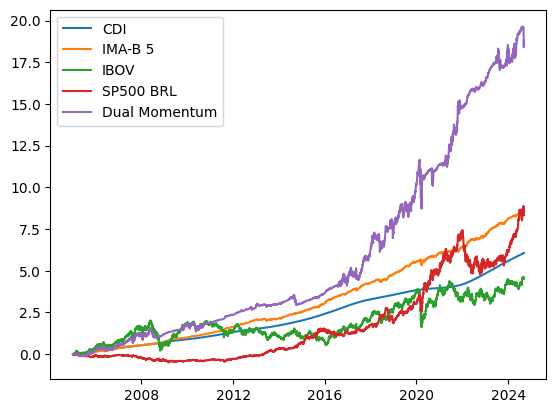

In [42]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

In [43]:
dual_momentum_eval = dual_momentum_eval + 1
dual_momentum_eval.index = pd.to_datetime(dual_momentum_eval.index)

series_start = dual_momentum_eval.index.min()
series_end = dual_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (dual_momentum_eval.iloc[-1] / (dual_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = dual_momentum.std() * (252 ** 0.5)

In [44]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.10) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
CDI,0.104498,0.002382,1.888371
IMA-B 5,0.121776,0.028586,0.761785
IBOV,0.090810,0.266251,-0.034516
SP500 BRL,0.121210,0.209242,0.101367
Dual Momentum,0.163784,0.161374,0.395255


### Benchmark

In [45]:
naive_portfolio = dual_momentum_eval[['IBOV', 'SP500 BRL', 'CDI', 'IMA-B 5']].mean(axis=1).rename('Naive Portfolio')
naive_portfolio.index = pd.to_datetime(naive_portfolio.index).date

naive_portfolio

2005-01-06    1.000000
2005-01-07    1.002108
2005-01-10    0.998013
2005-01-11    0.998825
2005-01-12    1.001604
                ...   
2024-09-03    7.936897
2024-09-04    7.961925
2024-09-05    7.948934
2024-09-06    7.874026
2024-09-09    7.920953
Name: Naive Portfolio, Length: 4871, dtype: float64

In [46]:
absolute_model = pd.read_csv('data/export_absolute_model.csv', index_col=0)
absolute_model.index = pd.to_datetime(absolute_model.index).date

In [47]:
relative_model = pd.read_csv('data/export_relative_model.csv', index_col=0)
relative_model.index = pd.to_datetime(relative_model.index).date

In [48]:
benchmark_models = [
    naive_portfolio,
    absolute_model['Return'] + 1,
    relative_model['Return'],
    dual_momentum_eval['Dual Momentum'],
]

benchmark = pd.concat(benchmark_models, keys=['Naive Portfolio', 'Absolute Momentum', 'Relative Momentum', 'Dual Momentum'], join='inner', axis=1)

benchmark

,Naive Portfolio,Absolute Momentum,Relative Momentum,Dual Momentum
2005-01-06,1.000000,1.000000,1.000000,1.000000
2005-01-07,1.002108,1.000042,1.015595,1.000042
2005-01-10,0.998013,1.000466,0.996922,1.000466
2005-01-11,0.998825,1.001055,1.000123,1.001055
2005-01-12,1.001604,1.001567,1.005869,1.001567
...,...,...,...,...
2024-09-03,7.936897,6.455563,16.431781,20.023440
2024-09-04,7.961925,6.540033,16.444839,20.039353
2024-09-05,7.948934,6.558820,16.305028,19.868981
2024-09-06,7.874026,6.466085,15.924396,19.405151


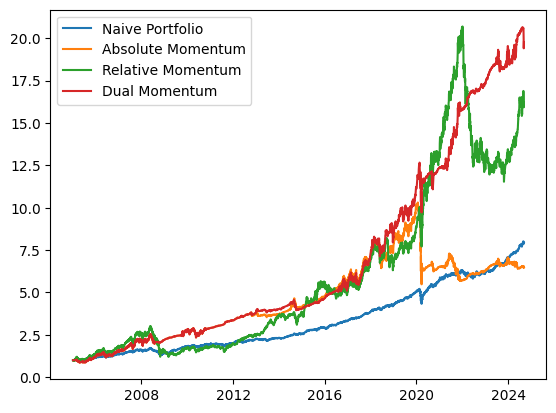

In [53]:
plt.plot(benchmark)
plt.legend(benchmark.columns)
plt.show()

In [50]:
dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-06,1.000000,1.000000,1.000000,1.000000,1.000000
2005-01-07,1.000648,1.000042,1.015595,0.992146,1.000042
2005-01-10,1.001297,1.000466,0.996922,0.993369,1.000466
2005-01-11,1.001946,1.001055,1.000123,0.992178,1.001055
2005-01-12,1.002596,1.001567,1.005869,0.996386,1.001567
...,...,...,...,...,...
2024-09-03,7.055960,9.559433,5.513728,9.618469,20.023440
2024-09-04,7.058731,9.576982,5.585874,9.626113,20.039353
2024-09-05,7.061503,9.588040,5.601921,9.544273,19.868981
2024-09-06,7.064276,9.587645,5.522715,9.321468,19.405151


In [56]:
series_start = benchmark.index.min()
series_end = benchmark.index.max()

years = (series_end - series_start).days / 365.25

benchmark_cagr = (benchmark.iloc[-1] / (benchmark.iloc[0])) ** (1 / years) - 1
benchmark_vol = benchmark.pct_change().std() * (252 ** 0.5)

In [57]:
total_results = pd.concat([benchmark_cagr, benchmark_vol], keys=['CAGR', 'Volatility'], axis=1)
total_results['Sharpe Ratio'] = (total_results['CAGR'] - 0.10) / total_results['Volatility']

total_results

,CAGR,Volatility,Sharpe Ratio
Naive Portfolio,0.110921,0.090697,0.120408
Absolute Momentum,0.099589,0.177445,-0.002317
Relative Momentum,0.152149,0.241278,0.216136
Dual Momentum,0.163784,0.161391,0.395215


In [71]:
benchmark_dd = (benchmark - benchmark.cummax()) / benchmark.cummax()

for col in benchmark_dd.columns:
    print(col, round(min(benchmark_dd[col]), 2) * 100, '%')

Naive Portfolio -27.0 %
Absolute Momentum -47.0 %
Relative Momentum -60.0 %
Dual Momentum -23.0 %
